<a href="https://colab.research.google.com/github/vcyrot/Machine_Learning/blob/main/Fashion_Image_Classification_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage import io
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt

## Data Preprocessing


In [ ]:
import PIL 

transform = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5), transforms.GaussianBlur(3,sigma=(0.1,2.0)),transforms.RandomRotation(45,resample=PIL.Image.BILINEAR)])

#Defining the training and testing set


In [ ]:
trainset=datasets.FashionMNIST('./data', download=True, train=True, transform = transform)
testset = datasets.FashionMNIST('./', download = True, train = False, transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=True)

In [ ]:
len(testset)

10000

## **Visualizing the Training Images**

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


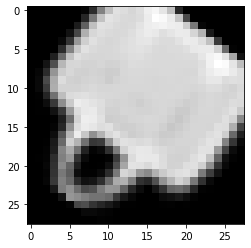

In [ ]:
plt.imshow(images[7].numpy().squeeze(), cmap='gray')

## **Defining the Neural Network**


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(1,4, kernel_size=3, stride=1, padding=1), #4 filters
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4,4, kernel_size=3, stride=1, padding=1), #4 filters
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

    )
    self.linear_layers=nn.Sequential(
        nn.Linear(4*7*7,10)
    )
  
  def forward(self, x):
    x=self.cnn_layers(x)
    x=x.view(x.size(0),-1)
    x=self.linear_layers(x)
    return x

In [ ]:
from torch.cuda import is_available
model = Net()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion= nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model=model.cuda()
  criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


## Training 


Epoch: 1 - Training Loss: 0.9316591991862254
Epoch: 2 - Training Loss: 0.79419030280891
Epoch: 3 - Training Loss: 0.7665341876780809
Epoch: 4 - Training Loss: 0.7466621013846733
Epoch: 5 - Training Loss: 0.737949230841228
Epoch: 6 - Training Loss: 0.7289207602487698
Epoch: 7 - Training Loss: 0.7280852584315262
Epoch: 8 - Training Loss: 0.7195988260606713
Epoch: 9 - Training Loss: 0.7146308179666747
Epoch: 10 - Training Loss: 0.7143781139715902


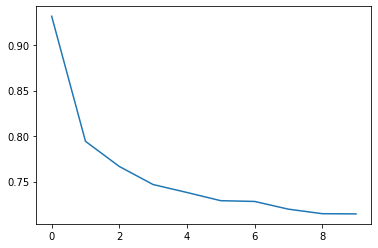

In [ ]:
loss_values = []
for i in range(0,10):
  running_loss=0
  for images, labels in trainloader:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()
    running_loss += loss.item()

  else:
    print("Epoch: {} - Training Loss: {}".format(i+1,running_loss/len(trainloader)))
    loss_values.append(running_loss/len(trainloader))

#Plotting the loss
plt.plot(loss_values)

## Testing



In [ ]:
correct_count, all_count = 0, 0

for images, labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    img = images[i].view(1,1,28,28)
    with torch.no_grad():
      logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[1]

    if (true_label == pred_label):
      correct_count += 1

    all_count +=1

print("Number of Images Tested =", all_count)
print ("Model Accuracy: ", (correct_count/all_count))